In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/asl_dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='training',
                                             seed=42, label_mode='categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.3,
                                             subset='validation',
                                             seed=42, label_mode='categorical')

Found 2515 files belonging to 36 classes.
Using 1761 files for training.
Found 2515 files belonging to 36 classes.
Using 754 files for validation.


TypeError: ignored

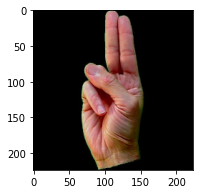

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation


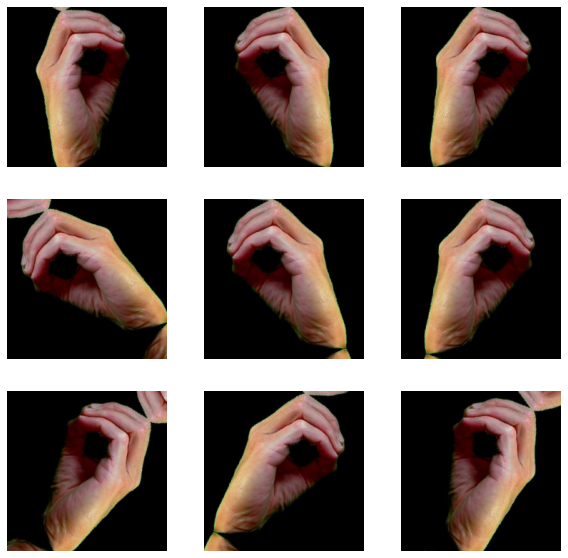

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')


22675456/22661472 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [12]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

flatten
Predictions


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [14]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)
tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n02786058', 'Band_Aid', 0.1982328), ('n03929660', 'pick', 0.039578557)],
 [('n02786058', 'Band_Aid', 0.066571966), ('n03929660', 'pick', 0.04346483)],
 [('n02786058', 'Band_Aid', 0.21376696),
  ('n02317335', 'starfish', 0.052459963)],
 [('n02786058', 'Band_Aid', 0.09030828),
  ('n01728920', 'ringneck_snake', 0.06544487)],
 [('n02786058', 'Band_Aid', 0.32341418), ('n03627232', 'knot', 0.03564827)],
 [('n02786058', 'Band_Aid', 0.079953365), ('n03929660', 'pick', 0.041039098)],
 [('n02786058', 'Band_Aid', 0.3722604), ('n02317335', 'starfish', 0.07468679)],
 [('n03494278', 'harmonica', 0.07908578),
  ('n03729826', 'matchstick', 0.049991187)],
 [('n02786058', 'Band_Aid', 0.3000556),
  ('n01728920', 'ringneck_snake', 0.036785234)],
 [('n02786058', 'Band_Aid', 0.15333208),
  ('n01914609', 'sea_anemone', 0.070249)],
 [('n01728920', 'ringneck_snake', 0.15245116),
  ('n01728572', 'thunder_snake', 0.061548978)],
 [('n02786058', 'Band_Aid', 0.2909915), ('n03804744', 'nail', 0.030453302)],
 [('

In [15]:
def asl_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x) 
  x = base_model(x)
  x = tfl.GlobalAveragePooling2D()(x)
  
  prediction_layer = tfl.Dense(36,activation="softmax")
  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model


In [16]:
with tf.device('/device:GPU:0'):
  model = asl_model(IMG_SIZE, data_augmentation)
  lr = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

12697600/12683000 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 36)                34596     
                                                                 
Total params: 3,030,948
Trainable params: 34,596
Non-trainabl

In [18]:
with tf.device('/device:GPU:0'):
  initial_epochs = 50
  history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
56/56 [==============================] - 318s 6s/step - loss: 3.0954 - accuracy: 0.2010 - val_loss: 2.6008 - val_accuracy: 0.3634
Epoch 2/50
56/56 [==============================] - 77s 1s/step - loss: 2.0829 - accuracy: 0.4895 - val_loss: 2.0407 - val_accuracy: 0.5371
Epoch 3/50
56/56 [==============================] - 77s 1s/step - loss: 1.5775 - accuracy: 0.6661 - val_loss: 1.6974 - val_accuracy: 0.6247
Epoch 4/50
56/56 [==============================] - 79s 1s/step - loss: 1.2942 - accuracy: 0.7365 - val_loss: 1.4724 - val_accuracy: 0.6817
Epoch 5/50
56/56 [==============================] - 77s 1s/step - loss: 1.0926 - accuracy: 0.7876 - val_loss: 1.3140 - val_accuracy: 0.7215
Epoch 6/50
56/56 [==============================] - 78s 1s/step - loss: 0.9639 - accuracy: 0.8132 - val_loss: 1.1738 - val_accuracy: 0.7560
Epoch 7/50
56/56 [==============================] - 78s 1s/step - loss: 0.8493 - accuracy: 0.8342 - val_loss: 1.0880 - val_accuracy: 0.7732
Epoch 8/50
56/56 [=

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 36)                34596     
                                                                 
Total params: 3,030,948
Trainable params: 34,596
Non-trainabl

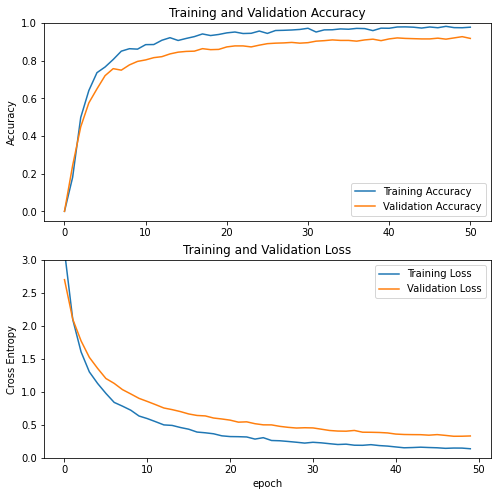

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
print('Highest Accuracy: {}%'.format(max(history.history['accuracy'])*100))
print('Highest Validation Accuracy: {}%'.format(max(history.history['val_accuracy'])*100))

Highest Accuracy: 98.12606573104858%
Highest Validation Accuracy: 92.83819794654846%
